# Control theory. Course introduction.

## TP3. Controllability and Observability
## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP2.ipynb)    

The completed notebooks should be sent to your tutor (elena.vanneaux@ensta.fr or adnan.saood@ensta.fr) before the beginning of the next session. Please add [APM_4AUT2_TA] to the topic of e-mail.

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

    5. Control System Library https://python-control.readthedocs.io/en/0.10.1/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# x is a state vecot, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix, 
# u_func(t) is a control input, w_func(t) is a disturbance input 
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    # return (C @ solution.T) 
    return (solution.T) 

def PID(A, B, D, C, Kp, Ki, Kd, r_func, w_func, T, x0):
    z0 = np.array([[0.0]])
    x_a =  np.block([[x0.reshape(-1,1)],[z0]])
    M = np.eye(x0.shape[0]) + Kd*B @ C
    A_a = np.block([[np.linalg.inv(M) @ (A - Kp * B @ C), -Ki * np.linalg.inv(M) @ B ], [C, np.array([0.0])]])
    B_a =  np.block([[Kp * np.linalg.inv(M) @ B ], [np.array([1.0])]])
    D_a = np.block([[np.linalg.inv(M) @ D],[np.array([[0.0]])]])
    C_a = np.block([C, np.array([[0.0]])])
    return OpenLoopInputOutputSystem(A_a, B_a, D_a, C_a, r_func, w_func, T, x_a.flatten()).T

Text(0, 0.5, 'Position ')

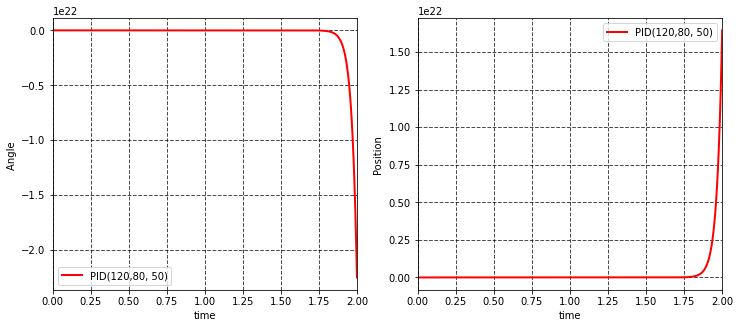

In [2]:
import sympy as sp
from matplotlib.pyplot import *
# Answer to EX1 q1 using symbolic calculs
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))

A = np.array(jacobian_A.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float)
B = np.array(jacobian_B.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float).reshape(4,1)
C = np.array([[1,0,0,0],[0,0,1,0]]) 
D = B

x0 = np.array([0,
               0,
               0,
               0])  # initial state

MatC = np.array([[0,0,1,0]]) # Let us assume that we measure only theta
y_ref = 1 # and we want to track constant reference equal to 1 rad. The latter correspond a state responce if the system

Kp= 120;
Ki = 80;
Kd = 50;

t0 = 0 # Initial time 
tf = 2 # Final time
T = np.linspace(t0, tf, 1000) 

def w_func(t):
       return 1.0# Disturbance input

def r_func(t):
       return 0.0# Disturbance input


solution = PID(A, B, D, MatC , Kp, Ki, Kd, r_func, w_func, T, x0)


figure(figsize=(12, 5))
y = solution[:,2]

subplot(1, 2, 1)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Angle ')

y = solution[:,0]
subplot(1, 2, 2)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Position ')

## Ex 1. Duality of Controllability and Observability

Prove that a pair of matrices (A,B) is controllable if and only if a pair of matrices (A^T, B^T) is observable.

First, let's prove that $ rank(A)=rank(A^\intercal)$.

The rank of a matrix is the number of independent rows or column of that matrix. As the transpose transforms the rows in columns and vice-versa, the number of independent columns in A is equal to the number of independant rows in A^T. Thus : 
$$ rank(A)=rank(A^\intercal) $$

Now, let's prove that $(A,B)$ is controllable if and only if $(A^T, B^T)$ is observable.

$(A,B)$ is controllable, so : 
$$
rank(\mathcal{C}(A,B)) = n
$$
Then :
$$
rank(\mathcal{C}(A,B)^\intercal) = n
$$
Which means :
$$
rank \begin{bmatrix} B^T \\ (AB)^T \\ ... \\ (A^{n-1}B)^T \end{bmatrix} = n
$$
Which is equivalent to :
$$
rank \begin{bmatrix} B^T \\ B^T A^T \\ ... \\ B^T A^{n-1} \end{bmatrix} = n
$$

Which, according to the definition of an observable pair of matrixes, is equivalent to $rank(\mathcal{O}(A^T,B^T)) = n$.

We thus proved the question.

## Ex 2. Invariance Under Nonsingular Transformations.

Consider $\dot x = Ax + Bu$ and similarity transformation $\tilde x = Tx$, where $T$ is invertible.

Prove that the system $\dot x = Ax + Bu$ is controllable if and only if the system  $\dot {\tilde x} = \tilde{A}\tilde{x} + \tilde{B}u$ is controllable.

Kalman's Controllability Rank Condition states that this system is controllable if and only if $rank(C(\tilde{A},\tilde{B})) = n$

Which is equivalent to :
$$
rank \begin{bmatrix} \tilde{B} & \tilde{A}\tilde{B} & ... & \tilde{A}^{n-1}\tilde{B}\end{bmatrix} = n
$$

Which is equivalent to : 
$$
rank \begin{bmatrix} TB & (TAT^{-1})TB & ... & (TAT^{-1})^{n-1}TB\end{bmatrix} = n
$$

T is invertible, which gives : 
$$
rank \begin{bmatrix} TB & TAB & ... & TA^{n-1}B\end{bmatrix} = n
$$

Which is equivalent to :
$$rank( 
T*\begin{bmatrix} B & AB & ... & A^{n-1}B\end{bmatrix}) = n$$

T is invertible, so it is a full-rank matrix, so we have : 
$$ rank(T*A) = rank(A)$$

Which means : 
$$rank \begin{bmatrix} B & AB & ... & A^{n-1}B\end{bmatrix} = n$$

Which is the definition of the system $\dot x = Ax+Bu$ being controllable.

## Ex 3. Quadruple-Tank Process

![WaterTanks.png](attachment:08b25ed2-2627-4f32-996f-e05af2180c8a.png)

Let us consider the Quadruple-Tank Process. A schematic diagram of the process is shown in the Figure above. The
target is to control the level in the lower two tanks with two pumps. The process inputs are $v_1$ and $v_2$ (input voltages to the pumps) and the outputs are $y_1$ and $y_2$ (water levels in the lower two tanks). Mass balances and Bernoulli’s law yield:

$$
\dfrac{dh_1}{dt} = -\dfrac{a_1}{A_1}\sqrt{2gh_1} + \dfrac{a_3}{A_1}\sqrt{2gh_3} + \dfrac{\gamma_1k_1}{A_1}v_1 = f_1(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_2}{dt} = -\dfrac{a_2}{A_2}\sqrt{2gh_2} + \dfrac{a_4}{A_2}\sqrt{2gh_4} + \dfrac{\gamma_2k_2}{A_2}v_2 = f_2(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_3}{dt} = -\dfrac{a_3}{A_3}\sqrt{2gh_3} + \dfrac{(1-\gamma_2)k_2}{A_3}v_2 = f_3(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_4}{dt} = -\dfrac{a_4}{A_4}\sqrt{2gh_4} + \dfrac{(1-\gamma_1)k_1}{A_4}v_1 = f_4(h_1,h_2,h_3,h_4,v_1,v_2)
$$
where

$A_i$ is a cross-section of Tank i

$a_i$ is a cross-section of outlet hole of Tank i

$h_i$ is a water level.

The voltage applied to Pump $i$ is $v_i$ and the corresponding flow
is $k_iv_i$. The parameters $\gamma_1,\gamma_2\in (0,1)$ are determined from how the valves are set prior to experiment. The flow to Tank 1
is $\gamma_1k_1v_1$ and the flow to Tank 4 is $(1-\gamma_1)k_1v_1$ and similarly
for Tank 2 and Tank 3. The acceleration of gravity is denoted $g$.
The measured level signals are $k_c h_1$ and $k_c h_2$. The parameter
values of the laboratory process are given in the following table

    A_1, A_3 [cm^2] 28
    A_2, A_4 [cm^2] 32
    a_1, a_3 [cm^2] 0.071
    a_2, a_4 [cm^2] 0.057
    k_c [V/cm] 0.50
    g [cm/s^2] 9.81
    k_1 [cm^3/Vs] 3.33
    k_2 [cm^3/Vs] 3.35
    gamma_1 0.70
    gamma_2 0.60
    
Check the following paper for more details on the model. 
https://www.diva-portal.org/smash/get/diva2:495784/FULLTEXT01.pdf
    
## TODO
1. Linearise the system around the operating point 
$$(h_1^0,h_2^0,h_3^0,h_4^0, v_1^0, v_2^0) = (12.4,12.7,1.8,1.4,3.00,3.00).$$
Pass to shifted variables $x_i = h_i-h_i^0, u_i = v_i - v_i^0.$

2. Is the linear system controllable? Is the linear system observable? Use the Kalman rank test to answer this question.

3. Imagine that one of the pumps is broken and there is no flow through it. Does the system remain controllable?

4. Let us measure the signals $x_3, x_4$ (i.e. matix $C = \begin{pmatrix}0&0&1&0\\0&0&0&1\end{pmatrix}$) instead of measuring the signals $x_1$ and $x_2.$ Is such a system observable?

Remark. The functions control.ctrb and control.obsv from control system library might be useful to comple. https://python-control.readthedocs.io/en/0.10.1/generated/control.obsv.html 

### Question 1
Let's linearize the system around the given operating point, using the shifted variables $x_i = h_i -h_i^0$ and $u_i = v_i - v_i^0$.

We get :
$$
\large
\frac{dx}{dt} = \begin{bmatrix} 
-\frac{1}{T_1} & 0 & \frac{A_3}{A_1 T_3} & 0 \\
0 & -\frac{1}{T_2} & 0 & \frac{A_4}{A_2 T_4} \\
0 & 0 & \frac{-1}{T_3} & 0 \\
0 & 0 & 0 & \frac{-1}{T_4} \end{bmatrix} x + 
\begin{bmatrix} 
\frac{\gamma_1 k_1}{A_1} & 0 \\
0 & \frac{\gamma_2 k_2}{A_2} \\
0 & \frac{(1-\gamma_2) k_2}{A_3} \\
\frac{(1-\gamma_1) k_1}{A_4} & 0 \end{bmatrix} u 
$$

$\large T_i = \frac{A_i}{a_i}\sqrt{\frac{2h_i^0}{g}}$, $i=1,..,4$

### Question 2 : is the system controllable and observable  ? 

We have $A = \begin{bmatrix} 
-\frac{1}{T_1} & 0 & \frac{A_3}{A_1 T_3} & 0 \\
0 & -\frac{1}{T_2} & 0 & \frac{A_4}{A_2 T_4} \\
0 & 0 & \frac{-1}{T_3} & 0 \\
0 & 0 & 0 & \frac{-1}{T_4} \end{bmatrix}$, $B = \begin{bmatrix} 
\frac{\gamma_1 k_1}{A_1} & 0 \\
0 & \frac{\gamma_2 k_2}{A_2} \\
0 & \frac{(1-\gamma_2) k_2}{A_3} \\
\frac{(1-\gamma_1) k_1}{A_4} & 0 \end{bmatrix}$,  $C = \begin{bmatrix} k_c &0&0&0 \\ 0& k_c &0&0 \end{bmatrix}$ and $ D = \begin{bmatrix}0&0\\0&0\end{bmatrix} $

Let's use the python control library to find out if the system is controllable.

In [5]:
!pip install control

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 KB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:01


In [18]:
import control
import numpy as np

# Let's input all the parameters :

A_1, A_3 = 28, 28
A_2, A_4 = 32, 32
a_1, a_3 = 0.071, 0.071
a_2, a_4 = 0.057, 0.057
k_c = 0.50
g = 9.81
k_1 = 3.33
k_2 = 3.35
gamma_1 = 0.70
gamma_2 = 0.60

h01 = 12.4
h02 = 12.7
h03 = 1.8
h04 = 1.4
v01 = 3.00
v02 = 3.00

T1 = np.sqrt((2*h01)/g)*A_1/a_1
T2 = np.sqrt((2*h02)/g)*A_2/a_2
T3 = np.sqrt((2*h03)/g)*A_3/a_3
T4 = np.sqrt((2*h04)/g)*A_4/a_4

A = np.array([[-1/T1, 0, A_3/(A_1*T3), 0], [0, -1/T2, 0, A_4/(A_2*T4)], [0, 0, -1/T3, 0], [0, 0, 0, -1/T4]])
B = np.array([[gamma_1*k_1/A_1, 0], [0, gamma_2*k_2/A_2], [0, (1-gamma_2)*k_2/A_3], [(1-gamma_1)*k_1/A_4, 0]])
C = np.array([[k_c, 0, 0, 0], [0, k_c, 0, 0]])
D = np.zeros((2,2))
print(A)
print(B)
print(C)
print(D)

[[-0.00159481  0.          0.00418585  0.        ]
 [ 0.         -0.00110699  0.          0.00333411]
 [ 0.          0.         -0.00418585  0.        ]
 [ 0.          0.          0.         -0.00333411]]
[[0.08325    0.        ]
 [0.         0.0628125 ]
 [0.         0.04785714]
 [0.03121875 0.        ]]
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]]
[[0. 0.]
 [0. 0.]]


In [25]:
system = control.ss(A, B, C, D)

ctrb_m = control.ctrb(system.A, system.B)
obsv_m = control.obsv(system.A, system.C)
C_rank = np.linalg.matrix_rank(ctrb_m)
O_rank = np.linalg.matrix_rank(obsv_m)

print("Controllability matrix rank :", C_rank)
print("Observability matrix rank :", O_rank)

Controllability matrix rank : 4
Observability matrix rank : 4


We see that both ranks are equal to 4. As n is also equal to 4, the system is both controllable and observable.

### Question 3 : Does the system remain controllable with one of the two pumps broken ?

First, let's suppose that pump number 1 is broken. We then have $B = \begin{bmatrix} 
0 & 0 \\
0 & \frac{\gamma_2 k_2}{A_2} \\
0 & \frac{(1-\gamma_2) k_2}{A_3} \\
0 & 0 \end{bmatrix} $. 
Let's run the python code again to see the results.

In [28]:
B2 = np.array([[0, 0], [0, gamma_2*k_2/A_2], [0, (1-gamma_2)*k_2/A_3], [0, 0]])
print(B2)

[[0.         0.        ]
 [0.         0.0628125 ]
 [0.         0.04785714]
 [0.         0.        ]]


In [31]:
B2 = np.array([[0, 0], [0, gamma_2*k_2/A_2], [0, (1-gamma_2)*k_2/A_3], [0, 0]])
print(B2)

system_2 = control.ss(A, B2, C, D)

ctrb_m = control.ctrb(system_2.A, system_2.B)
obsv_m = control.obsv(system_2.A, system_2.C)
C_rank = np.linalg.matrix_rank(ctrb_m)
O_rank = np.linalg.matrix_rank(obsv_m)

print("Controllability matrix rank :", C_rank)

[[0.         0.        ]
 [0.         0.0628125 ]
 [0.         0.04785714]
 [0.         0.        ]]
Controllability matrix rank : 3


We see that the rank of the controllability matrix drops to 3. Let's try for the other pump :

In [32]:
B3 = np.array([[gamma_1*k_1/A_1, 0], [0, 0], [0, 0], [(1-gamma_1)*k_1/A_4, 0]])
print(B3)

system_3 = control.ss(A, B3, C, D)

ctrb_m = control.ctrb(system_3.A, system_3.B)
obsv_m = control.obsv(system_3.A, system_3.C)
C_rank = np.linalg.matrix_rank(ctrb_m)
O_rank = np.linalg.matrix_rank(obsv_m)

print("Controllability matrix rank :", C_rank)

[[0.08325    0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.03121875 0.        ]]
Controllability matrix rank : 3


We get the result we expected.

Thus, the system is no longer controllable with one of the two pumps broken, which is logical.

### Question 4 : changing the measured signals to $x_3$ and $x_4$, does the system remain observable? 

The only difference with the question 2 is the matrix C, which becomes $C = \begin{bmatrix}0&0& k_c &0\\0&0&0& k_c\end{bmatrix}$

In [34]:
C2 = np.array([[0, 0, k_c, 0], [0, 0, 0, k_c]])

system_4 = control.ss(A, B, C2, D)

ctrb_m = control.ctrb(system_4.A, system_4.B)
obsv_m = control.obsv(system_4.A, system_4.C)
C_rank = np.linalg.matrix_rank(ctrb_m)
O_rank = np.linalg.matrix_rank(obsv_m)

print("Observability matrix rank :", O_rank)

Observability matrix rank : 2


The system isn't observable anymore.